In [ ]:
from pathlib import Path
import pandas as pd

base = Path(r"FOPPA_1.1.3_csv")  

for f in sorted(base.glob("*.csv")):
    cols = pd.read_csv(f, sep=None, engine="python", nrows=0).columns.tolist()
    print(f"{f.name} | {len(cols)} cols")
    print(cols, "\n")


Agents.csv | 10 cols
['agentId', 'name', 'siret', 'address', 'city', 'zipcode', 'country', 'department', 'longitude', 'latitude'] 

Criteria.csv | 5 cols
['criterionId', 'lotId', 'name', 'weight', 'type'] 

LotBuyers.csv | 2 cols
['lotId', 'agentId'] 

Lots.csv | 26 cols
['lotId', 'tedCanId', 'correctionsNb', 'cancelled', 'awardDate', 'awardEstimatedPrice', 'awardPrice', 'cpv', 'numberTenders', 'onBehalf', 'jointProcurement', 'fraAgreement', 'fraEstimated', 'lotsNumber', 'accelerated', 'outOfDirectives', 'contractorSme', 'numberTendersSme', 'subContracted', 'gpa', 'multipleCae', 'typeOfContract', 'topType', 'renewal', 'contractDuration', 'publicityDuration'] 

LotSuppliers.csv | 2 cols
['lotId', 'agentId'] 

Names.csv | 2 cols
['agentId', 'name'] 



In [3]:
from pathlib import Path
import pandas as pd

base = Path(r"FOPPA_1.1.3_csv")
read = lambda fn: pd.read_csv(base/fn, sep=None, engine="python")

Agents       = read("Agents.csv")
Criteria     = read("Criteria.csv")
LotBuyers    = read("LotBuyers.csv")
LotSuppliers = read("LotSuppliers.csv")
Lots         = read("Lots.csv")

{n: df.shape for n, df in {
    "Agents":Agents, "Criteria":Criteria,
    "LotBuyers":LotBuyers, "LotSuppliers":LotSuppliers, "Lots":Lots}.items()}


{'Agents': (301096, 10),
 'Criteria': (2910408, 5),
 'LotBuyers': (1497632, 2),
 'LotSuppliers': (1371535, 2),
 'Lots': (1380965, 26)}

In [5]:
# fix types
Lots["awardDate"] = pd.to_datetime(Lots["awardDate"], errors="coerce")
num_cols = [c for c in ["awardEstimatedPrice","awardPrice","numberTenders","numberTendersSme",
                        "contractDuration","publicityDuration","lotsNumber","correctionsNb"] if c in Lots.columns]
Lots[num_cols] = Lots[num_cols].apply(pd.to_numeric, errors="coerce")


In [6]:
# basics
display(Lots[num_cols].describe().T)
display(Lots["awardDate"].agg(["min","max"]))


,count,mean,std,min,25%,50%,75%,max
awardEstimatedPrice,189613.0,3.043616e+06,3.283510e+08,0.01,23634.0000,100000.0,379895.66,1.000000e+11
awardPrice,954642.0,2.095028e+14,1.447420e+17,0.00,12045.2075,69965.0,280000.00,1.000000e+20
numberTenders,956866.0,6.773685e+00,1.594821e+01,0.00,2.0000,3.0,6.00,9.990000e+02
numberTendersSme,44026.0,3.116318e+00,6.116334e+00,0.00,1.0000,2.0,3.00,7.700000e+01
contractDuration,842768.0,2.861253e+01,2.115915e+01,0.03,12.0000,24.0,48.00,9.990000e+02
publicityDuration,1035374.0,4.364077e+01,2.124315e+01,-41.00,35.0000,42.0,49.00,3.694000e+03
lotsNumber,1069384.0,1.124519e+13,3.526625e+15,0.00,2.0000,4.0,11.00,2.010024e+18
correctionsNb,1380965.0,3.815448e-03,6.269958e-02,0.00,0.0000,0.0,0.00,2.000000e+00


min   2000-01-20
max   2089-01-07
Name: awardDate, dtype: datetime64[ns]

In [7]:
# missingness
display(Lots.isna().mean().sort_values(ascending=False).head(15).to_frame("missing_rate"))


,missing_rate
accelerated,0.998150
numberTendersSme,0.968119
awardEstimatedPrice,0.862695
fraEstimated,0.827143
contractorSme,0.677376
jointProcurement,0.609871
multipleCae,0.608065
subContracted,0.493311
renewal,0.480705
contractDuration,0.389725


In [8]:
# key categoricals
display(Lots["typeOfContract"].value_counts(dropna=False).head(10))
display(Lots["topType"].value_counts(dropna=False).head(10))
display(Lots["numberTenders"].value_counts().sort_index().head(15))


typeOfContract
U    554638
S    550055
W    276272
Name: count, dtype: int64

topType
OPE    1165396
NIC     103848
AWP      65077
RES      24152
NOC      17736
COD       2799
NIP       1227
NOP        506
NaN        191
INP         33
Name: count, dtype: int64

numberTenders
0.0       1918
1.0     151923
2.0     174030
3.0     167128
4.0     129149
5.0      89056
6.0      57451
7.0      37990
8.0      26313
9.0      18525
10.0     13543
11.0      9427
12.0      7555
13.0      5469
14.0      4764
Name: count, dtype: int64

In [9]:
# cpv overview + single-bid rate
Lots["cpv2"] = Lots["cpv"].astype(str).str[:2]
display(Lots["cpv2"].value_counts().head(10))
float((Lots["numberTenders"]==1).mean())


cpv2
45    265727
33    188818
15     78745
71     76483
90     72807
50     68140
60     65967
79     56469
34     55164
39     47859
Name: count, dtype: int64

0.11001220161264044

In [10]:
# buyer–supplier edges
edges = LotBuyers.merge(LotSuppliers, on="lotId", suffixes=("_buyer","_supplier")) \
                 .merge(Lots[["lotId","awardPrice","numberTenders","awardDate"]], on="lotId", how="left")
edges.head()


,lotId,agentId_buyer,agentId_supplier,awardPrice,numberTenders,awardDate
0,0,89779,144381,891674.70,NaN,2009-09-24
1,1,89779,101371,116925.11,NaN,2009-09-24
2,2,89779,143487,73814.12,NaN,2009-09-24
3,3,4689,112901,384058.40,11.0,2009-09-28
4,4,258710,159848,7790000.00,6.0,2009-11-06


In [11]:
# buyer aggregates
buyers = edges.groupby("agentId_buyer").agg(
    n_lots=("lotId","nunique"),
    suppliers=("agentId_supplier","nunique"),
    spend=("awardPrice","sum"),
    single_bid_rate=("numberTenders", lambda s: (s==1).mean()),
    first_year=("awardDate","min"),
    last_year=("awardDate","max"),
).sort_values(["spend","n_lots"], ascending=False)
buyers.head(10)


,n_lots,suppliers,spend,single_bid_rate,first_year,last_year
agentId_buyer,,,,,,
2598,462,301,2.000001e+20,0.286008,2009-12-21,2020-12-24
81609,115,105,6.040011e+13,0.120301,2010-03-25,2020-12-22
87917,271,194,6.040007e+13,0.210702,2010-07-23,2020-11-23
87862,46,49,6.040001e+13,0.072727,2010-10-11,2019-07-31
1104,14,12,6.040000e+13,0.142857,2018-07-17,2019-06-05
87848,14,12,6.040000e+13,0.142857,2018-07-17,2019-06-05
87871,14,12,6.040000e+13,0.142857,2018-07-17,2019-06-05
87872,14,12,6.040000e+13,0.142857,2018-07-17,2019-06-05
87878,14,12,6.040000e+13,0.142857,2018-07-17,2019-06-05


In [12]:
# supplier aggregates
suppliers = edges.groupby("agentId_supplier").agg(
    n_lots=("lotId","nunique"),
    buyers=("agentId_buyer","nunique"),
    revenue=("awardPrice","sum"),
    single_bid_rate=("numberTenders", lambda s: (s==1).mean()),
    first_year=("awardDate","min"),
    last_year=("awardDate","max"),
).sort_values(["revenue","n_lots"], ascending=False)
suppliers.head(10)


,n_lots,buyers,revenue,single_bid_rate,first_year,last_year
agentId_supplier,,,,,,
102476,126,69,1.000001e+20,0.047244,2009-11-10,2020-01-29
99680,14,8,1.000000e+20,0.000000,2009-12-30,2017-07-10
139305,12,26,1.717000e+14,0.086957,2015-07-07,2019-06-04
135565,2,17,1.717000e+14,0.500000,2019-06-03,2019-06-04
288495,14,60,1.700002e+14,0.016393,2018-05-03,2020-08-10
159627,7,21,1.700000e+14,0.739130,2013-06-21,2020-10-20
219634,2,18,1.700000e+14,0.000000,2019-06-04,2019-10-28
172431,5,16,1.300000e+14,0.000000,2015-09-23,2018-10-19
3224,31,18,1.000056e+13,0.193548,2010-05-07,2019-08-14


# FOPPA 1.1.3 dataset overview (for graphs)

**Tables and size**
- **Lots** — 1,380,965 rows, 26 cols: `lotId`, `awardDate`, `awardPrice`, `cpv`, `numberTenders`, procedure/type flags
- **Agents** — 301,096 rows, 10 cols: buyers and suppliers with geo fields
- **LotBuyers** — 1,497,632 rows (lot → buyer)
- **LotSuppliers** — 1,371,535 rows (lot → supplier)
- **Criteria** — 2,910,408 rows (evaluation criteria)
- **Names** — alternative names for agents

**Quick profile**
- Dates contain outliers; target period 2010-2020
- High missingness in some fields: `accelerated`, `numberTendersSme`, `awardEstimatedPrice`, `fraEstimated`
- Usable signals: `numberTenders`, `awardPrice`, `cpv`, `typeOfContract`, `topType`
- Single-bid share ≈ 11% where `numberTenders` is present
- CPV leaders by 2-digit code: `45`, `33`, `15`, `71`, `90`, etc.

**Cleaning choices for graph work**
- Keep 2010-2020
- Cast numerics; keep NaN as unknown
- Cap extreme `awardPrice` at 99.9 percentile and drop non-positive
- Build buyer–supplier edges by joining LotBuyers × LotSuppliers × Lots
- Aggregates:
  - `buyers`: `n_lots`, distinct `suppliers`, `spend`, `sb_rate`
  - `suppliers`: `n_lots`, distinct `buyers`, `revenue`, `sb_rate`
  - `pair_year` per (buyer, supplier, year): `n_lots`, `value`, `sb_rate`


In [13]:
# cleaning
from pathlib import Path
import pandas as pd

base = Path(r"FOPPA_1.1.3_csv")
read = lambda fn: pd.read_csv(base/fn, sep=None, engine="python")

Agents       = read("Agents.csv")
LotBuyers    = read("LotBuyers.csv")
LotSuppliers = read("LotSuppliers.csv")
Lots         = read("Lots.csv")

Lots["awardDate"] = pd.to_datetime(Lots["awardDate"], errors="coerce")
for c in ["awardEstimatedPrice","awardPrice","numberTenders","numberTendersSme",
          "contractDuration","publicityDuration","lotsNumber","correctionsNb"]:
    if c in Lots: Lots[c] = pd.to_numeric(Lots[c], errors="coerce")

L = Lots[Lots["awardDate"].between("2010-01-01","2020-12-31")].copy()
q = L["awardPrice"].quantile(0.999)
L.loc[L["awardPrice"]<=0, "awardPrice"] = pd.NA
L = L[(L["awardPrice"].isna()) | (L["awardPrice"]<=q)].copy()

edges = (LotBuyers.merge(LotSuppliers, on="lotId", suffixes=("_buyer","_supplier"))
                 .merge(L[["lotId","awardPrice","numberTenders","awardDate","cpv","typeOfContract","topType"]],
                        on="lotId", how="inner"))

buyers = edges.groupby("agentId_buyer").agg(
    n_lots=("lotId","nunique"),
    suppliers=("agentId_supplier","nunique"),
    spend=("awardPrice","sum"),
    sb_rate=("numberTenders", lambda s: (s==1).mean()),
).reset_index()

suppliers = edges.groupby("agentId_supplier").agg(
    n_lots=("lotId","nunique"),
    buyers=("agentId_buyer","nunique"),
    revenue=("awardPrice","sum"),
    sb_rate=("numberTenders", lambda s: (s==1).mean()),
).reset_index()

pair_year = (edges.assign(year=edges["awardDate"].dt.year)
                  .groupby(["agentId_buyer","agentId_supplier","year"])
                  .agg(n_lots=("lotId","nunique"),
                       value=("awardPrice","sum"),
                       single_bids=("numberTenders", lambda s: (s==1).sum()))
                  .reset_index())
pair_year["sb_rate"] = pair_year["single_bids"]/pair_year["n_lots"]


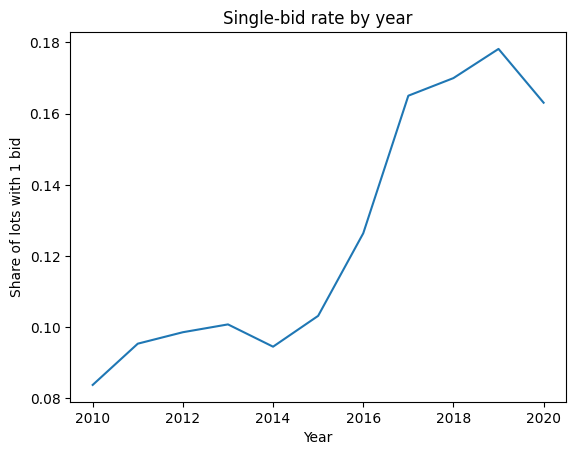

In [14]:
# viz 1: single-bid rate by year
import matplotlib.pyplot as plt

yearly = (edges.assign(year=edges["awardDate"].dt.year)
               .groupby("year")
               .agg(sb_rate=("numberTenders", lambda s: (s==1).mean()))
               .reset_index()
               .sort_values("year"))

plt.figure()
plt.plot(yearly["year"], yearly["sb_rate"])
plt.title("Single-bid rate by year")
plt.xlabel("Year"); plt.ylabel("Share of lots with 1 bid")
plt.show()


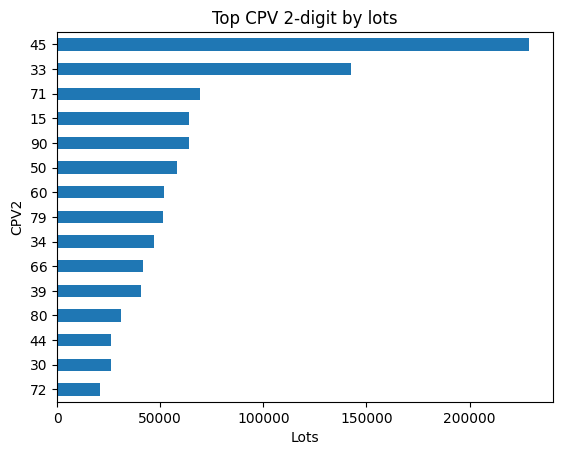

In [15]:
# viz 2: top CPV 2-digit families
import matplotlib.pyplot as plt

cpv2 = (L["cpv"].astype(str).str[:2].value_counts().head(15))[::-1]
plt.figure()
cpv2.plot(kind="barh")
plt.title("Top CPV 2-digit by lots")
plt.xlabel("Lots"); plt.ylabel("CPV2")
plt.show()


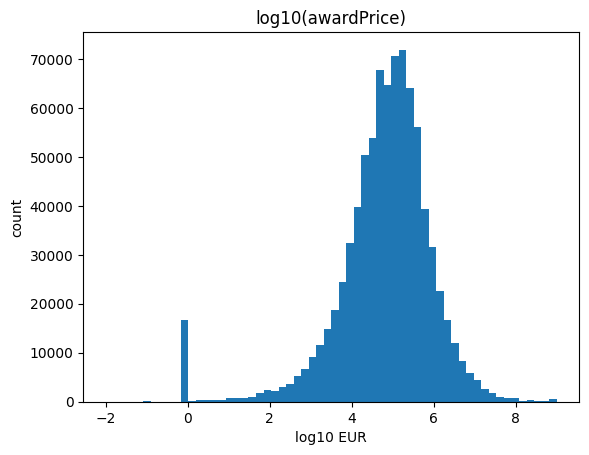

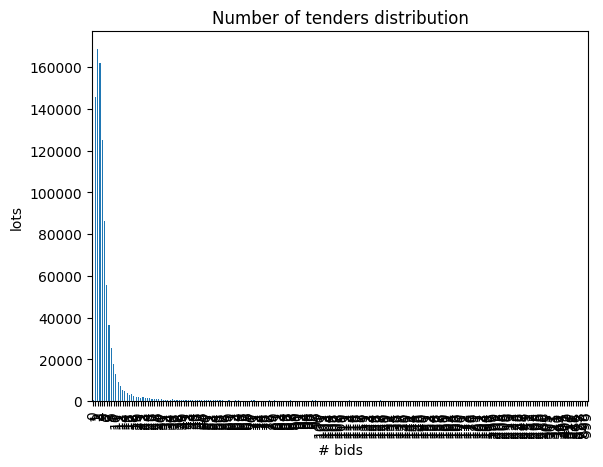

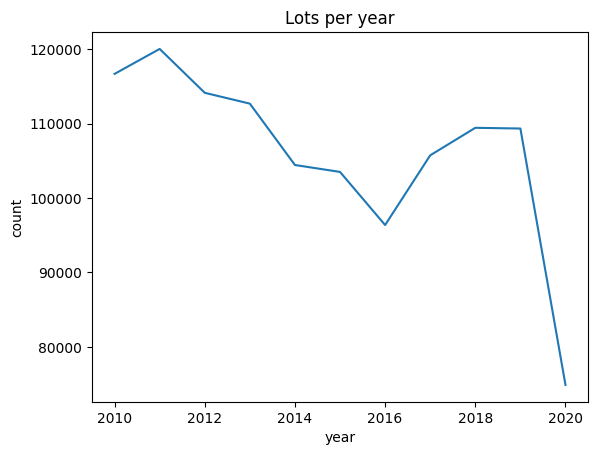

In [16]:
# distributions & trends
import numpy as np
import matplotlib.pyplot as plt

tmp = L.copy()
tmp["year"] = tmp["awardDate"].dt.year

x = np.log10(tmp["awardPrice"].dropna()[lambda s: s>0])
plt.figure(); plt.hist(x, bins=60); plt.title("log10(awardPrice)"); plt.xlabel("log10 EUR"); plt.ylabel("count"); plt.show()

plt.figure(); tmp["numberTenders"].dropna().astype(int).value_counts().sort_index().plot(kind="bar")
plt.title("Number of tenders distribution"); plt.xlabel("# bids"); plt.ylabel("lots"); plt.show()

year_counts = tmp.groupby("year")["lotId"].count().reset_index()
plt.figure(); plt.plot(year_counts["year"], year_counts["lotId"]); plt.title("Lots per year"); plt.xlabel("year"); plt.ylabel("count"); plt.show()


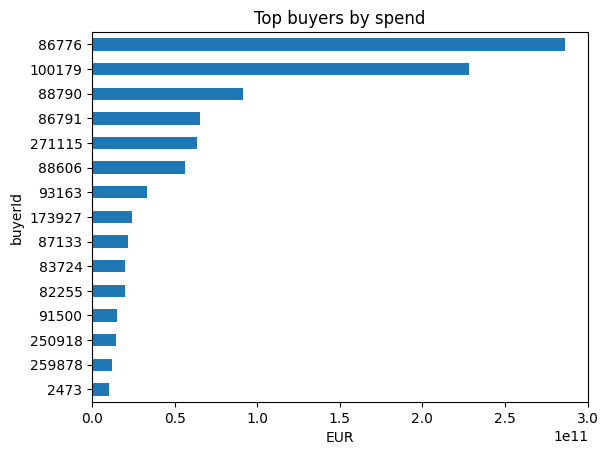

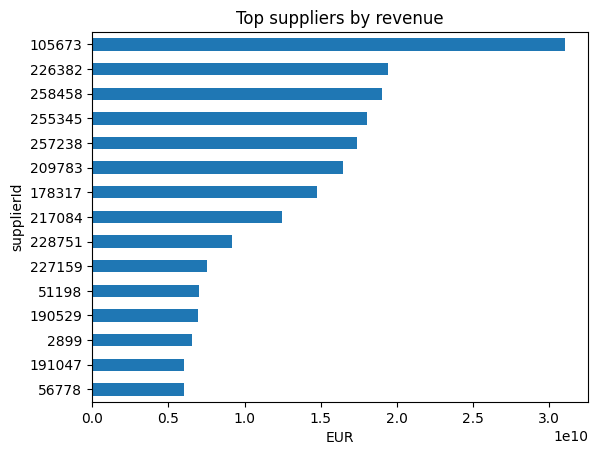

In [17]:
# top buyers / suppliers
import matplotlib.pyplot as plt

topB = buyers.nlargest(15, "spend").set_index("agentId_buyer")["spend"][::-1]
plt.figure(); topB.plot(kind="barh"); plt.title("Top buyers by spend"); plt.xlabel("EUR"); plt.ylabel("buyerId"); plt.show()

topS = suppliers.nlargest(15, "revenue").set_index("agentId_supplier")["revenue"][::-1]
plt.figure(); topS.plot(kind="barh"); plt.title("Top suppliers by revenue"); plt.xlabel("EUR"); plt.ylabel("supplierId"); plt.show()


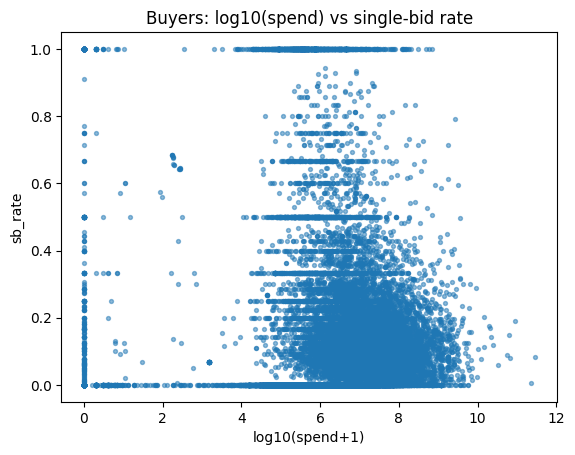

In [18]:
# spend vs single-bid rate (buyers)
import matplotlib.pyplot as plt
b = buyers.dropna(subset=["sb_rate","spend"])
plt.figure(); plt.scatter(np.log10(b["spend"]+1), b["sb_rate"], s=8, alpha=0.5)
plt.title("Buyers: log10(spend) vs single-bid rate"); plt.xlabel("log10(spend+1)"); plt.ylabel("sb_rate"); plt.show()


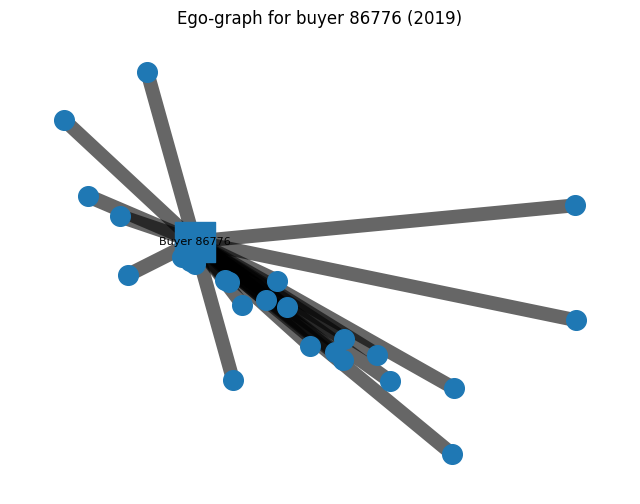

In [19]:
# small ego-graph for one buyer (year-filtered)
import networkx as nx
import numpy as np

year = 2019
ey = edges[edges["awardDate"].dt.year==year].copy()
by = ey.groupby(["agentId_buyer","agentId_supplier"]).agg(
    value=("awardPrice","sum"), n=("lotId","nunique")
).reset_index()

b_id = by.groupby("agentId_buyer")["value"].sum().sort_values(ascending=False).index[0]
ego = by[by["agentId_buyer"]==b_id].nlargest(25, "value")  # top 25 suppliers

G = nx.Graph()
G.add_node(("B", b_id))
for _,r in ego.iterrows():
    sid = int(r["agentId_supplier"])
    G.add_node(("S", sid))
    G.add_edge(("B", b_id), ("S", sid), weight=float(r["value"]), n=int(r["n"]))

pos = nx.spring_layout(G, seed=7)
plt.figure(figsize=(8,6))
# draw buyer
nx.draw_networkx_nodes(G, pos, nodelist=[("B", b_id)], node_shape="s", node_size=800)
# draw suppliers
sup_nodes = [n for n in G.nodes if n[0]=="S"]
nx.draw_networkx_nodes(G, pos, nodelist=sup_nodes, node_shape="o", node_size=200)
# draw edges with width ~ log(value)
w = [1+np.log10(1+G[u][v]["weight"]) for u,v in G.edges()]
nx.draw_networkx_edges(G, pos, width=w, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=8, labels={("B", b_id): f"Buyer {b_id}"})
plt.title(f"Ego-graph for buyer {b_id} ({year})")
plt.axis("off"); plt.show()


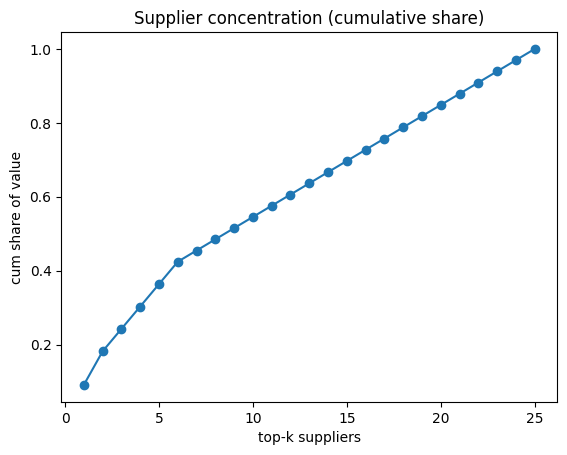

In [21]:
# supplier concentration curve for that buyer (share by supplier)
p = ego.sort_values("value", ascending=False).reset_index(drop=True)
p["share"] = p["value"]/p["value"].sum()
p["cum_share"] = p["share"].cumsum()
plt.figure(); plt.plot(np.arange(1, len(p)+1), p["cum_share"], marker="o")
plt.title("Supplier concentration (cumulative share)"); plt.xlabel("top-k suppliers"); plt.ylabel("cum share of value"); plt.show()


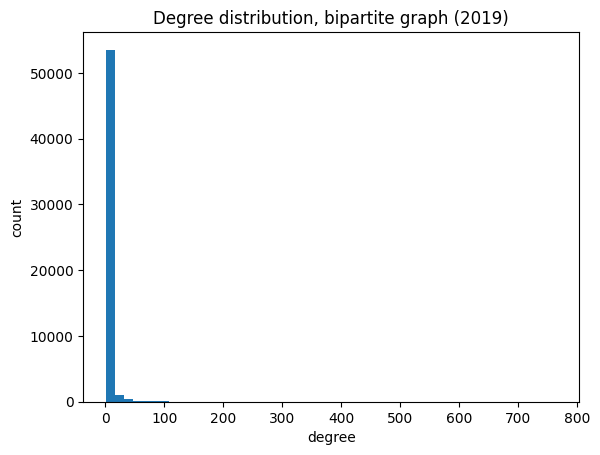

In [22]:
# buyer–supplier degree distributions (year)
import matplotlib.pyplot as plt

Gy = nx.from_pandas_edgelist(by, source="agentId_buyer", target="agentId_supplier")
deg = [d for _,d in Gy.degree()]
plt.figure(); plt.hist(deg, bins=50); plt.title(f"Degree distribution, bipartite graph ({year})"); plt.xlabel("degree"); plt.ylabel("count"); plt.show()


In [ ]:
# optional: map ids to names for labeling 
from pathlib import Path
nm_path = base/"Names.csv"
if nm_path.exists():
    Names = pd.read_csv(nm_path, sep=None, engine="python")
    id2name = dict(Names.dropna(subset=["agentId","name"]).drop_duplicates("agentId").values)
else:
    id2name = dict(Agents[["agentId","name"]].dropna().drop_duplicates("agentId").values)

# example: display top buyer name
id2name.get(b_id, f"buyer {b_id}")


'VILLE DE LYON'